# Credit Risk with Quantum Amplitude Estimation (QAE)

> Contact : Ziyuan Li (stan.ziyuan.li@hsbc.com.cn) 

```
************************************************
Goal of this technotes:
    1. Know the idea of credit risk and general approach to perform analysis with quantum algorithm
    2. Know how to prepare the quantum circuit for this task
    3. Know how to run Credit Risk with Qiskit
************************************************   
```

## Motivation
The economic capital requirement is the difference between the value at risk and the expected loss. It is designed to cover losses between the expected loss and the value at risk at a given confidence level. Extreme losses, i.e., those beyond the value at risk, are not covered by the economic capital requirement

<img src="https://raw.githubusercontent.com/ZiyuanLi007/quantumalg/main/technotes/images/cr/qcalg_cr_ecr.png" width="500">

For a portfolio of $K$ assets the multivariate random variable $(L_1, L_2, ..., L_K)$ denotes each possible loss associated to each asset. The expected value of the total loss is $E[L] = \sum_{k=1}^K E[L_K]$. The value at risk (VaR) for a given confidence level $\alpha$ is defined as the smallest total loss that still has a probability greater than or equal to $\alpha$, i.e.,

$$ \text{VaR}_{\alpha}(L) = \inf_{x \ge 0} \{ x \mid \mathbb{P}[L <= x] \geq \alpha \}$$

The economic capital requirement at confidence level $\alpha$ is thus defined as the difference between the value at risk and the expected loss

$$ \text{ECR}_{\alpha}(L) = \text{VaR}_{\alpha}(L) - E[L] $$

Quantum amplitude estimation algorithm can be used to estimate financial risk measures such as the value at risk and the conditional value at risk with a quadratic speedup compared to classical Monte Carlo simulations.



## 1. Conditional Independence Model

For simplicity, if  we assume that all losses are independent and can be expressed as $L_k = \lambda_k X_k$, where $\lambda_k > 0$ is the loss given default (LGD) and $X_k \in \{0,1\}$ is corresponding Bernoulli random variable. The probability that $X_k = 1$, i.e., a loss for asset k, is $p_k$. The expected total loss is given by $E[L] = \sum_{k=1}^K \lambda_k p_k$. 

In practice, asset defaults are often correlated, especially in periods of financial stress. The defaults $X_k$ are no longer independent but follow a condi- tional independence scheme, i.e., given a value $z$ sampled from a latent random variable $Z$ following a standard normal distribution, the default probability of asset $k$ is given by

$$p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$

where $F$ denotes the cumulative distribution function of $Z$, $p_k^0$ is the default probability of asset $k$ for $z=0$ and $\rho_k$ is the sensitivity of the default probability of asset $k$ with respect to $Z$. Thus, given a concrete realization of $Z$ the individual default events are assumed to be independent from each other. The expected loss is

$$ E[L] = \int_{z=-\infty}^{\infty} \sum_{k=1}^K \lambda_k p_k(z) f(z) dz $$

where $f(z)$ is the PDF function of $Z$

## 2. Quantum Circuit Construction
To apply quantum computation, the primary task is to load the correlated default risk for each asset of the portfolio into the quantum circuit.

<h3><center> High level circuit of the operator $A$</center></h3>
<img src="https://raw.githubusercontent.com/ZiyuanLi007/quantumalg/main/technotes/images/cr/qcalg_cr_Acircuit.png" width="600">

The first qubit register with $n_Z$ qubits represents the latent random variable $Z$, the second qubit register with $K$ qubits represents the Bernoulli random variables $X_k$ of each asset, the third qubit register with $n_S$ qubits represents the sum of the losses. Then it comes to the comparator operator $C$ and the last qubit is flipped to $|1\rangle$ if the total loss is less than or equal to a given $x$



### Step 1. Load  Z distribution using operator $U_Z$
We use $n_z$ qubits to discretize the distribution to $2^{n_z}$ slots. 

<img src="https://raw.githubusercontent.com/ZiyuanLi007/quantumalg/main/technotes/images/cr/qcalg_cr_UZ.png" width="300">

Operator $U_Z$ (**GaussianConditionalIndependenceModel**) inputs the state $|0\rangle^{\otimes n_z}$ for these $n_z$ qubits, and output $|\psi\rangle_{U_Z}$, a superposition of $2^{n_z}$ entangled states:

$$|\psi\rangle_{U_Z} = \sum_{z=0}^{2^{n_z}-1} \sqrt{f(z)} |z\rangle$$

### Step 2. Load  uncorrelated default using operator using operator $L_X$
When the default events $\{X_1, X_2, ..., X_K\}$ are uncorrelated, we can encode the $X_k$ of each asset in the state of a corresponding qubit by applying to qubit $k$ a Y-rotation $R_Y(\theta_p^k)$ with angle $\theta_p^k = 2 \arcsin(\sqrt{p_k^0})$. The operator $L_X$ involves $n_x$ qubits to load the $n_x$ independent assets. For each of the $n_x$ qubits, operator $L_X$ inputs the initial state $|0\rangle^{\otimes n_x}$ and outputs the state:

$$|\psi\rangle_{L_X} = (\sqrt{1-p_k^0}|0\rangle + \sqrt{p_k^0}|1\rangle)^{\otimes n_x}$$

so that the probability for state $|1\rangle$ encodes the default probability $p_k^0$ 

### Step 3. Load correlated default using operator $L_Z$
The qubit register representing $Z$ is then used to control the rotation angles $\theta_p^k(z) = 2 \arcsin(\sqrt{p_k(z)})$ that prepare the qubits representing the $X_k$. For simplicity, a first order approximation of $\theta_p^k(z)$ and include the affine mapping from $z$ to $i$ ($i \in \{0, ..., 2^{n_z}-1\}$), i.e. $\theta_p^k(z) \approx a_k i + b_k$.

<h3><center>The qubit representing $X_k$ is prepared using Y-rotations controlled by the qubits representing Z.</center></h3>
<img src="https://raw.githubusercontent.com/ZiyuanLi007/quantumalg/main/technotes/images/cr/qcalg_cr_LZ.png" width="600">

In short, operator $L_Z$ inputs $\sum_{z=0}^{2^{n_z}-1} \sqrt{f(z)} |z\rangle$ and $(\sqrt{1-p_k^0}|0\rangle + \sqrt{p_k^0}|1\rangle)^{\otimes n_x}$ from $U_Z$ and $U_X$ and outputs the further entangled state:

$$|\psi\rangle_{L_Z} = \sum_{z=0}^{2^{n_z}-1} \sqrt{f(z)} |z\rangle (\sqrt{1-p_k(z)}|0\rangle + \sqrt{p_k(z)}|1\rangle)^{\otimes n_x}$$


### Step 4. Load total loss using operator $S$

Furthermore, we set an operator $S$ to sum up the loss due to all default events in this asset pool. The maximum loss would be $\sum \lambda_k$ when all assets default, so ensuring the maximum loss to be encoded needs $n_s$ qubits that $\sum \lambda_k \le 2^{n_s} − 1$. The operator $S$ (**WeightedAdder**) inputs the state $|\psi\rangle_{L_Z} |0\rangle^{\otimes 2^{n_s} − 1}$, and output the state

$$|\psi\rangle_{S} = |\psi\rangle_{L_Z} | \sum_{k=1}^K \lambda_k p_k(z) \rangle_{ns} |c\rangle^{\otimes {n_s} − 1} $$

The first $n_s$ qubits are used to load the sum of loss $L = \sum_{k=1}^K \lambda_k p_k(z)$. The next $n_s − 1$ qubits are used as the carry qubits $|c\rangle$. 

Once we have the total loss distribution in a quantum register, we can map a total loss $L \in \{0, ..., 2^{n_s}-1\}$ to the amplitude of an objective qubit by an operator (**LinearAmplitudeFunction**)

$$ | L \rangle_{n_s}|0\rangle \mapsto 
| L \rangle_{n_s} \left( \sqrt{1 - L/(2^{n_s}-1)}|0\rangle + \sqrt{L/(2^{n_s}-1)}|1\rangle \right), $$

which allows to run quantum amplitude estimation (**IterativeAmplitudeEstimation**) to evaluate the expected loss $E[L]$.

### Step 5. Calculate Cumulative Distribution Function  using operator $C$

To estimate the CDF, i.e., the probability $\mathbb{P}[L \leq x]$, we apply a comparator $C$ (**IntegerComparator**) that for a given value $x$ acts as

$$ \mathcal{C}: |L\rangle_n|0\rangle \mapsto 
\begin{cases} 
|L\rangle_n|1\rangle & \text{if}\quad L \leq x \\
|L\rangle_n|0\rangle & \text{if}\quad L > x.
\end{cases} $$

The resulting quantum state can be written as

$$ \sum_{L = 0}^{x} \sqrt{p_{L}}|L\rangle_{n_s}|1\rangle + 
\sum_{L = x+1}^{2^{n_s}-1} \sqrt{p_{L}}|L\rangle_{n_s}|0\rangle, $$

The CDF($x$) equals the probability of measuring $|1\rangle$ in the objective qubit and quantum amplitude estimation (**IterativeAmplitudeEstimation**) can be directly used to estimate it.

**Then we perform the bisection search for the value at risk.**

### Step 6. Apply Quantum Amplitude Estimation to extract amplitude
This estimation is obtained with quantum phase estimation and an operator $Q$ based on $A$ and defined by

$$Q=A S_0 A^{\dagger} S_{\psi_0}$$
$$S_0 = I - 2 |0\rangle \langle 0|$$ 
$$S_{\psi_0} = I - 2 |\psi_0\rangle \langle \psi_0|$$

<img src="https://raw.githubusercontent.com/ZiyuanLi007/quantumalg/main/technotes/images/cr/qcalg_cr_Qcircuit.png" width="40%" /> 

The operator $Q$ essentially causes a Y-rotation of angle $2 \theta_a$ , i.e., $Q=R_y(2\theta_a)$.

Quantum amplitude estimation requires $m$ additional evaluation qubits and $M=2^m - 1$ applications of the $Q$ operator. 

<img src="https://raw.githubusercontent.com/ZiyuanLi007/quantumalg/main/technotes/images/cr/qcalg_cr_QAE.png" width="40%" />

After applying the Inverse Quantum Fourier Transform, we got:
$$QFT^{-1}(\frac{1}{\sqrt{2^m}}\sum_{j=0}^{2^m-1}e^{2 i \theta_a j}|j\rangle|\psi\rangle) = \frac{1}{\pi}|\theta_a\rangle|\psi\rangle$$

By taking measurement on the register of $m$ qubits, we can get the approximation of $\theta_a$.

## 3. Practice with Qiskit

### 1. Define the problem and parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.library import IntegerComparator
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, FasterAmplitudeEstimation, EstimationProblem, AmplitudeEstimation, MaximumLikelihoodAmplitudeEstimation
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI
from qiskit.compiler import transpile

# set problem parameters

# UZ
n_z = 5
z_max = n_z
z_values = np.linspace(-z_max, z_max, 2 ** n_z)

# LX
p_zeros = [0.15, 0.25, 0.15, 0.1]
rhos = [0.1, 0.05, 0.1, 0.02]
lgd = [1, 2, 2, 1]
K = len(p_zeros)
alpha = 0.05

# LZ : Load Uncertainty Model
u = GCI(n_z, z_max, p_zeros, rhos)

### 2. Solve with classical calculation to get exact results

In [2]:
# run the circuit and analyze the results
job = execute(u, backend=Aer.get_backend("statevector_simulator"))

# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2 ** n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):

    # get binary representation
    b = ("{0:0%sb}" % num_qubits).format(i)
    prob = np.abs(a) ** 2

    # extract value of Z and corresponding probability
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if b[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]

values = np.array(values)
probabilities = np.array(probabilities)

expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                1.0314
Value at Risk VaR[L]:              3.0000
P[L <= VaR[L]]:                    0.9528
Conditional Value at Risk CVaR[L]: 4.2772


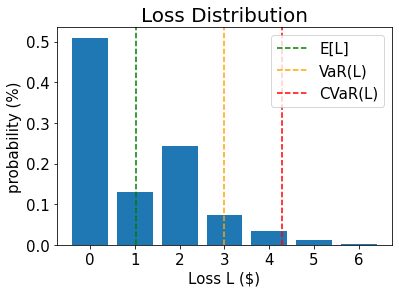

In [3]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

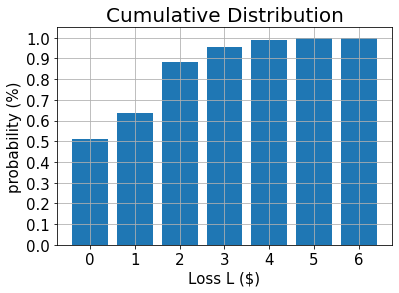

In [4]:
# plot CDF
plt.bar(losses, cdf)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Cumulative Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.yticks(np.arange(0, 1.01, 1e-1))
plt.grid()
plt.show()

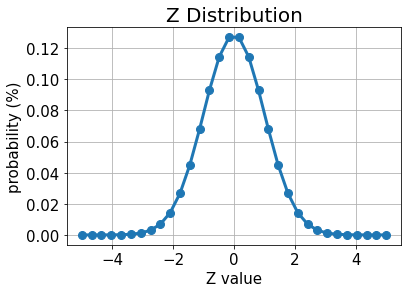

In [5]:
# plot Uncertainty Model Z
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 3. Construct the A operator for Expected Loss $E[L]$

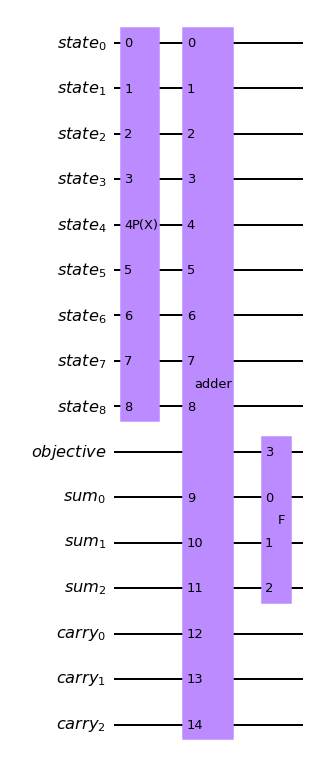

In [6]:
# add Z qubits with weight/loss 0
from qiskit.circuit.library import WeightedAdder
agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

from qiskit.circuit.library import LinearAmplitudeFunction
# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2 ** agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
qr_obj = QuantumRegister(1, "objective")

def get_expectedloss_circuit(): 
    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

    # linear objective function
    state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

    # uncompute aggregation
    #state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

    return state_preparation

state_preparation = get_expectedloss_circuit()
#state_preparation.measure_all()
# draw the circuit
state_preparation.draw()

# visuilize circuit
# basic_gates=['u1', 'u2', 'u3', 'cx', 'ry', 'rx', 'rz']
# state_preparation_transpile = transpile(state_preparation, basis_gates=basic_gates, optimization_level=3)
# state_preparation_transpile.draw(output='mpl')

### Execute QAE to estimate $E[L]$

In [7]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)

# construct amplitude estimation
#ae = AmplitudeEstimation(num_eval_qubits=3, quantum_instance=qi)
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
#ae = MaximumLikelihoodAmplitudeEstimation(evaluation_schedule=4, quantum_instance=qi)
#ae = FasterAmplitudeEstimation(delta=0.01,maxiter=3,quantum_instance=qi,)
result = ae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	1.0314
Estimated value:	1.0553
Confidence interval: 	[1.0151, 1.0956]


### 4. Construct the A operator for Cumulative Distribution Function $C[L]$

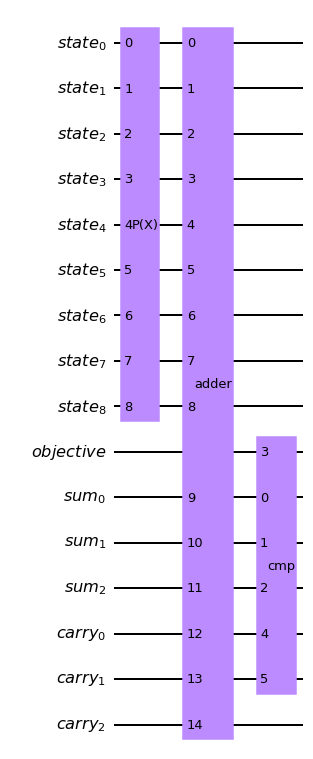

In [8]:
# set x value to estimate the CDF
x_eval = 2

# comparator objective function
comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)

# define the registers for convenience and readability
qr_compare = QuantumRegister(1, "compare")
    
def get_cdf_circuit(x_eval):
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:-1])

    # uncompute aggregation
    #state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

    return state_preparation

state_preparation = get_cdf_circuit(x_eval)
state_preparation.draw()

### Execute QAE to estimate $C[L]$

In [9]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=300)
problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
ae_cdf = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result_cdf = ae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % cdf[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.8807
Estimated value:	0.8808
Confidence interval: 	[0.8799, 0.8816]


### 5. Perform Bisection Search  to get the value at risk $\text{VaR}_{\alpha}(L)$

In [10]:
def run_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05, simulator="aer_simulator"):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    ae_var = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
    result_var = ae_var.estimate(problem)

    return result_var.estimation

def bisection_search(
    objective, target_value, low_level, high_level, low_value=None, high_value=None
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print("--------------------------------------------------------------------")
    print("start bisection search for target value %.3f" % target_value)
    print("--------------------------------------------------------------------")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}

    # check if high_value is above target
    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    # perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("--------------------------------------------------------------------")
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print("--------------------------------------------------------------------")
    print("finished bisection search")
    print("--------------------------------------------------------------------")
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}

In [11]:
# run bisection search to determine VaR
objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(
    objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1
)
var = bisection_result["level"]

print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[exact_var])

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         2       0.880     6            1.000
 2           0.880         4       0.988     6            1.000
 2           0.880         3       0.954     4            0.988
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------
Estimated Value at Risk:  3
Exact Value at Risk:      3
Estimated Probability:    0.954
Exact Probability:        0.953


> Reference 
> 1. https://jsybruce.github.io/Homepage/2021/12/01/Option-Pricing-with-Quantum-Monte-Carlo-Simulation-copy.html
> 2. S. Woerner and D. J. Egger, “Quantum risk analysis,” NPJ Quantum Inf., vol. 5, 2019, Art. no. 15.
> 3. D. Egger, R. Garcia Gutierrez, J. Mestre and S. Woerner, "Credit Risk Analysis Using Quantum Computers" in IEEE Transactions on Computers, vol. 70, no. 12, pp. 2136-2145, 2021.
> 4. H.Tang, et al., "Quantum computation for pricing the collateralized debt obligations", Quantum Engineering (2021)